In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import numpy as np

In [2]:
def get_moves_from_csv(csv_file):
    moves = []
    with open(csv_file, 'rt') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            moves.append([[int(x) for x in row[0: 9]], int(row[9])])
    return moves

In [3]:
moves = get_moves_from_csv('base_tic_tac_toe_data.csv')

In [4]:
print(moves[0])

[[1, -1, 0, -1, 0, 0, 0, 0, 0], 7]


In [5]:
moves = np.array(moves)
train_indices = np.array(np.random.choice(len(moves), round(len(moves) * 0.8), replace=False))
test_indices = np.array(list(set(range(len(moves))) - set(train_indices)))
train_set = moves[train_indices]
test_set = moves[test_indices]
x_vals_train = np.array([x[0] for x in train_set])
y_vals_train = np.array([x[1] for x in train_set])
x_vals_test = np.array([x[0] for x in test_set])
y_vals_test = np.array([x[1] for x in test_set])

In [6]:
print(len(y_vals_train))

149


In [7]:
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape), dtype=tf.float32)

def model(X, A1, A2, A3, bias1, bias2, bias3, train_b):
    layer1 = tf.nn.relu(tf.add(tf.matmul(X, A1), bias1))
    if train_b[0] == 1:
        layer1 = tf.nn.dropout(layer1, 0.5)
    layer2 = tf.nn.relu(tf.add(tf.matmul(layer1, A2), bias2))
    if train_b[0] == 1:
        layer2 = tf.nn.dropout(layer2, 0.5)
    layer3 = tf.add(tf.matmul(layer2, A3), bias3)
    return layer3

In [8]:
X = tf.placeholder(dtype=tf.float32, shape=[None, 9])
Y = tf.placeholder(dtype=tf.int64, shape=[None])
train_b = tf.placeholder(dtype=tf.int32, shape=[1])
A1 = init_weights([9, 27])
bias1 = init_weights([27])
A2 = init_weights([27, 18])
bias2 = init_weights([18])
A3 = init_weights([18, 9])
bias3 = init_weights([9])
model_output = model(X, A1, A2, A3, bias1, bias2, bias3, train_b)

In [9]:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=Y))
train_step = tf.train.GradientDescentOptimizer(0.005).minimize(loss)
prediction = tf.argmax(model_output, 1)

In [10]:
accuracy = tf.equal(Y, prediction)

In [11]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)  
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
init = tf.global_variables_initializer()
sess.run(init)
loss_vec = []
loss_vec_test = []
acc_train = []
acc_test = []
for i in range(10000):
    rand_indices = np.random.choice(range(len(train_set)), 32, replace=False)
    x_input = x_vals_train[rand_indices]
    y_target = y_vals_train[rand_indices]
    sess.run(train_step, feed_dict={X: x_input, Y: y_target, train_b: [1]})
    temp_loss = sess.run(loss, feed_dict={X: x_input, Y: y_target})
    loss_vec.append(temp_loss)
    temp_loss_test = sess.run(loss, feed_dict={X: x_vals_test, Y: y_vals_test, train_b: [0]})
    loss_vec_test.append(temp_loss_test)
    temp_acc_train = np.sum(np.array(sess.run(accuracy, feed_dict={X: x_vals_train, Y: y_vals_train, train_b: [0]})).astype(np.float32))/y_vals_train.shape
    temp_acc_test = np.sum(np.array(sess.run(accuracy, feed_dict={X: x_vals_test, Y: y_vals_test, train_b: [0]})).astype(np.float32))/y_vals_test.shape
    acc_train.append(temp_acc_train)
    acc_test.append(temp_acc_test)
    if i % 500 == 0:
        print('iteration ' + str(i) + ' Loss: ' + str(temp_loss))

iteration 0 Loss: 16.536526
iteration 500 Loss: 1.445773
iteration 1000 Loss: 1.3784667
iteration 1500 Loss: 1.0490673
iteration 2000 Loss: 1.0013657
iteration 2500 Loss: 0.76999474
iteration 3000 Loss: 0.5732273
iteration 3500 Loss: 0.74816763
iteration 4000 Loss: 0.41952688
iteration 4500 Loss: 0.5666405
iteration 5000 Loss: 0.5110402
iteration 5500 Loss: 0.49605724
iteration 6000 Loss: 0.5493804
iteration 6500 Loss: 0.37562153
iteration 7000 Loss: 0.45283455
iteration 7500 Loss: 0.31682223
iteration 8000 Loss: 0.41768396
iteration 8500 Loss: 0.2686525
iteration 9000 Loss: 0.1924243
iteration 9500 Loss: 0.34330407


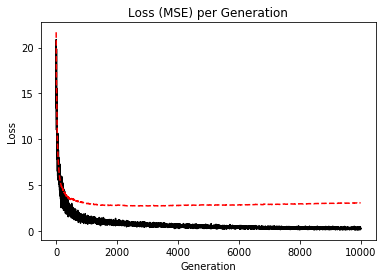

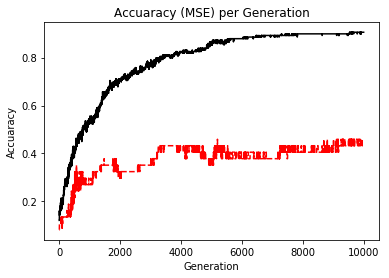

In [12]:
plt.plot(loss_vec, 'k-', label='Loss')
plt.plot(loss_vec_test, 'r--', label='Loss')
plt.title('Loss (MSE) per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()
plt.plot(acc_train, 'k-', label='Acc')
plt.plot(acc_test, 'r--', label='Acc')
plt.title('Accuaracy (MSE) per Generation')
plt.xlabel('Generation')
plt.ylabel('Accuaracy')
plt.show()

In [13]:
print(np.sum(np.array(sess.run(accuracy, feed_dict={X: x_vals_train, Y: y_vals_train, train_b: [0]})).astype(np.float32))/y_vals_train.shape)

[0.90604027]


In [14]:
print(np.sum(np.array(sess.run(accuracy, feed_dict={X: x_vals_test, Y: y_vals_test, train_b: [0]})).astype(np.float32))/y_vals_test.shape)

[0.43243243]


In [15]:
saver = tf.train.Saver()

In [16]:
import os
saver.save(sess, os.path.join(".\model", "model.ckpt"), global_step=10000)

'.\\model\\model.ckpt-10000'